In [35]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms
from scipy import stats

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(hexbin)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
    library(viridis)
})

options(dplyr.width = Inf)

## Load Glasser parcellation for right hemisphere

In [3]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices
glasser180_right_ctab = glasser180_right_ctab
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [12]:
# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

In [5]:
%%R -i oslom_modules_final_glasser180_right,module_orders -o oslom_modules_final_glasser180_right

# Tidy data
oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module_Number))%>% 
  filter(module != "Unassigned")

## Load Yeo 2011 7-network parcellation

In [6]:
yeo7_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot"
yeo7_right_vertices, yeo7_right_ctab, yeo7_right_names = fs.read_annot(yeo7_right_file)

yeo7_right_vertices = yeo7_right_vertices
yeo7_right_ctab = yeo7_right_ctab
yeo7_right_names = [name.decode() for name in yeo7_right_names]

# Create Yeo 7 right hemi lookup table
yeo7_right_LUT = pd.read_csv("yeo7_lookup.csv")

# Convert yeo17 array to dataframe
yeo7_right_df = pd.DataFrame({'index': yeo7_right_vertices, 'vertex_number': np.arange(0, len(yeo7_right_vertices))})
yeo7_right_df['Yeo7_RH_ROI'] = yeo7_right_df['index'].map(yeo7_right_LUT.set_index('index')['Yeo7_RH_ROI'])

# Drop index
yeo7_right_df = yeo7_right_df.drop(columns=['index'])

## Load Margulies 2016 principal gradient vertices

In [23]:
# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_PG1 = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_PG1_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG1, '164k', 'R')[0]
margulies_PG1_fsaverage_right_vertices = margulies_PG1_fsaverage_right.agg_data()

margulies_PG2 = fetch_annotation(source='margulies2016', desc='fcgradient02')
margulies_PG2_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG2, '164k', 'R')[0]
margulies_PG2_fsaverage_right_vertices = margulies_PG2_fsaverage_right.agg_data()

# Combine PG1 and PG2 across vertices
margulies_PG_fsaverage_right_df = pd.DataFrame({'PG1_value': margulies_PG1_fsaverage_right_vertices, 
                                                'PG2_value': margulies_PG2_fsaverage_right_vertices, 
                                                'vertex_number': np.arange(0, len(margulies_PG1_fsaverage_right_vertices))})


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cort

## Merge all the data!

In [24]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with Yeo 7 networks
merged_df = pd.merge(merged_df, yeo7_right_df, on='vertex_number', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_PG_fsaverage_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???" and Yeo7_RH_ROI != "???"')

## How do the overlapping regions compare with the Yeo 2011 17-network functional atlas?

In [9]:
ROI_Yeo_combinations = pd.DataFrame(pd.MultiIndex.from_product([merged_df.query("overlapping=='overlapping'")['Glasser_RH_ROI'].unique(), 
                                                                       merged_df['Yeo7_RH_ROI'].unique()], 
                                                                       names=['Glasser_RH_ROI', 'Yeo7_RH_ROI'])).reset_index()
# Split tuple in column '0' into separate columns
ROI_Yeo_combinations[['Glasser_RH_ROI', 'Yeo7_RH_ROI']] = pd.DataFrame(ROI_Yeo_combinations[0].tolist(), index=ROI_Yeo_combinations.index)
ROI_Yeo_combinations.drop(columns=[0], inplace=True)

num_vertices_in_each_yeo_ROI = (merged_df
                                .groupby(['Glasser_RH_ROI', 'Yeo7_RH_ROI'])
                                .size()
                                .reset_index(name='num_vertices')
                                .assign(total_vertices_in_Glasser=lambda d: d.groupby('Glasser_RH_ROI')['num_vertices'].transform('sum'))  # Compute total per Glasser
                                .assign(prop_vertices=lambda d: d['num_vertices'] / d['total_vertices_in_Glasser'])  # Compute proportion
                                .merge(oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')
                                .query("overlapping=='overlapping'")
                                .merge(ROI_Yeo_combinations, on=['Glasser_RH_ROI', 'Yeo7_RH_ROI'], how='outer')
                                .dropna(subset=['Yeo7_RH_ROI'])
)

In [124]:
%%R -i num_vertices_in_each_yeo_ROI

num_vertices_in_each_yeo_ROI %>% 
    mutate(Yeo7_RH_ROI = factor(Yeo7_RH_ROI, 
           levels=rev(c("Visual", "Somatomotor", "Dorsal attention", 
                        "Ventral attention", "Limbic", 
                        "Frontoparietal", "Default"))),
           ROI_label_short = gsub("_ROI", "", gsub("R_", "", Glasser_RH_ROI))) %>%
    mutate(ROI_label_short = factor(ROI_label_short, levels=c("ProS", "PreS", "PHA1", "POS2", "PeEc", "PGp", "PH",  "TE1a", 
                                                              "STSva", "RSC",  "8BM", "9m", "8Av", "PFm", "PGs"))) %>%
    ggplot(data=., mapping=aes(y=Yeo7_RH_ROI, x=ROI_label_short, fill=100*prop_vertices)) +
    geom_tile(linewidth=0.5) +
    xlab("Brain Region") +
    ylab("Yeo 7-Network Area") +
    labs(fill="% Vertices in Network") +
    scale_y_discrete(drop=FALSE, expand=c(0,0)) +
    scale_x_discrete(drop=FALSE, expand=c(0,0)) +
    # Fill with viridis and set NA to dark purple
    scale_fill_viridis(option="viridis", na.value="#440456") +   
    theme(legend.position="bottom",
          strip.background = element_blank(),
          axis.text.y = element_text(size=14),
          axis.text.x = element_text(angle=45, hjust=1, size=13))
# ggsave("../Plots/Overlapping_regions_vs_Yeo_atlas.svg", width=5.75, height=3.15, dpi=300, units="in")

## How do overlapping vs. non-overlapping modules compare in the principal Margulies gradient?

### One violin plot comparing distribution of PG1 values in overlapping vs. non-overlapping regions

In [129]:
# %%R -i merged_df 

# merged_df %>%
#     filter(module != "Unassigned") %>%
#     mutate(overlapping=factor(overlapping, levels=c("overlapping", "non-overlapping"))) %>%
#     ggplot(data=., mapping=aes(x=overlapping, y=PG1_value, fill=overlapping, color=overlapping)) +
#     geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
#     geom_point(position = position_jitter(width = 0.1, height=0),
#                             size = 1, alpha=0.1, stroke=0) +
#     stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
#             show.legend=FALSE, position = position_nudge(x=0.25)) +
#     ylab("Principal Gradient value (a.u.)") +
#     xlab("OSLOM Region Classification") +
#     facet_grid(. ~ overlapping, space="free", scales="free_x", switch="both") +
#     scale_fill_manual(values=c("overlapping"="#9F3BC5",
#                                "non-overlapping"="#c1cdbf")) +  
#     scale_color_manual(values=c("overlapping"="#9F3BC5",
#                                "non-overlapping"="#c1cdbf")) + 
#     theme(legend.position="none",
#           strip.background = element_blank(),
#           strip.text = element_blank())
# ggsave("../Plots/OSLOM_Classification_vs_Margulies_PG1_vertexwise.svg", width=5, height=5.5, units="in", dpi=300)

### Alternative violin plot with just the overlapping modules

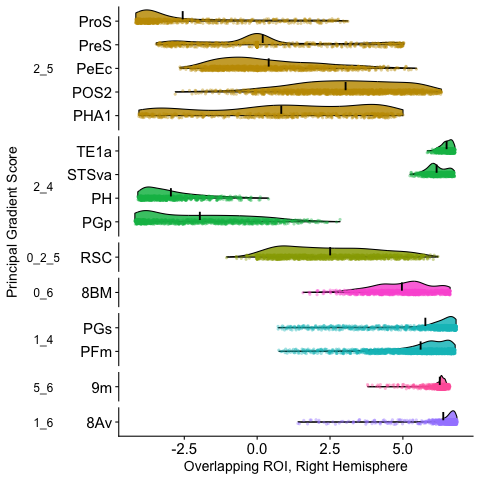

In [15]:
%%R -i merged_df,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

# Vertex-wise distributions
merged_df %>%
    filter(module != "Unassigned" & overlapping == "overlapping") %>%
    ungroup() %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, PG1_value, .fun=mean)) %>%
    mutate(module_fct = fct_reorder(module, PG1_value, .fun=mean)) %>%
    rowwise() %>%
    mutate(region_label = gsub("R_", "", str_split(Glasser_RH_ROI, "_ROI")[[1]][1])) %>%
    ggplot(data=., mapping=aes(x=region_label, y=PG1_value, fill=module, color=module)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.1, height=0),
                            size = 1.5, alpha=0.4, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    xlab("Principal Gradient Score") +
    ylab("Overlapping ROI, Right Hemisphere") +
    coord_flip() +
    facet_grid(module_fct ~ ., space="free", scales="free_y", switch="both") +
    scale_color_manual(values=colormap) +
    scale_fill_manual(values=colormap) +
    theme(legend.position = "none",
          strip.placement='outside',
          strip.text.y.left = element_text(angle=0),
          axis.text = element_text(size=15),
          strip.background = element_blank())
          
# ggsave("../Plots/Overlapping_Modules_vs_Margulies_PG1_voxelwise.svg", width=4.5, height=6, units="in", dpi=300)

### Compare the mean PG1 and PG2 values for each overlapping vs. non-overlapping region

In [69]:
mean_PG_value_by_region = (merged_df
                            .groupby(['Glasser_RH_ROI'])[['PG1_value', 'PG2_value']]
                            .mean()
                            .reset_index()
                            .merge(oslom_modules_final_glasser180_right, how='left'))

SD_PG_value_by_region  = (merged_df
                            .groupby(['Glasser_RH_ROI'])[['PG1_value', 'PG2_value']]
                            .std()
                            .reset_index()
                            .merge(oslom_modules_final_glasser180_right, how='left'))

,Glasser_RH_ROI,PG1_value,PG2_value,module,overlapping
0,R_10d_ROI,6.203862,-0.124382,6,non-overlapping
1,R_10pp_ROI,6.231446,-0.152121,5,non-overlapping
2,R_10r_ROI,5.667607,-0.075260,6,non-overlapping
3,R_10v_ROI,6.199069,-0.164263,6,non-overlapping
4,R_11l_ROI,2.146277,0.045854,2,non-overlapping
...,...,...,...,...,...
175,R_p9-46v_ROI,1.901944,0.370706,4,non-overlapping
176,R_pOFC_ROI,2.041529,-0.079788,2,non-overlapping
177,R_s32_ROI,5.646203,0.003334,6,non-overlapping
178,R_s6-8_ROI,4.602068,0.037365,6,non-overlapping


In [96]:
# Is the mean higher for PG1 overlapping regions?
PG1_overlap_means = mean_PG_value_by_region.query("overlapping=='overlapping'").PG1_value.values
PG1_nonoverlap_means = mean_PG_value_by_region.query("overlapping=='non-overlapping'").PG1_value.values
stats.ranksums(PG1_overlap_means,PG1_nonoverlap_means)

RanksumsResult(statistic=np.float64(2.884008802876259), pvalue=np.float64(0.003926477772592976))

In [97]:
# Is the mean higher for PG2 overlapping regions?
PG2_overlap_means = mean_PG_value_by_region.query("overlapping=='overlapping'").PG2_value.values
PG2_nonoverlap_means = mean_PG_value_by_region.query("overlapping=='non-overlapping'").PG2_value.values
stats.ranksums(PG2_overlap_means,PG2_nonoverlap_means)

RanksumsResult(statistic=np.float64(1.4732391538158507), pvalue=np.float64(0.14068656094779833))

In [54]:
%%R -i mean_PG_value_by_region

mean_PG_value_by_region %>% 
    filter(!is.na(overlapping)) %>%
    pivot_longer(cols=c(PG1_value,PG2_value), names_to="PG", values_to="value") %>% 
    mutate(PG = gsub("_value", "", PG)) %>% 
    ggplot(data=., mapping=aes(x=overlapping, y=value, fill=overlapping, color=overlapping)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.05, height=0),
                            size = 1.7, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    facet_wrap(PG ~ ., scales="free_y", ncol=1) +
    scale_fill_manual(values=c("overlapping"="#9F3BC5",
                               "non-overlapping"="#c1cdbf")) +  
    scale_color_manual(values=c("overlapping"="#9F3BC5",
                               "non-overlapping"="#c1cdbf")) +
    ylab("Gradient value (a.u.)") +
    xlab("") +
    theme(legend.position="none", 
          strip.text = element_text(size=14, face="bold"),
          strip.background=element_blank())
# ggsave("../Plots/Overlapping_Modules_vs_Margulies_PG1_means.svg", width=3.5, height=5, units="in", dpi=300)

In [93]:
%%R -i mean_PG_value_by_region,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

mean_PG_value_by_region %>% 
    filter(!is.na(overlapping)) %>%
    mutate(overlapping = factor(overlapping, levels=c("non-overlapping", "overlapping")),
           region_color = ifelse(overlapping=="overlapping", module, NA_character_),
           region_label = ifelse(overlapping=="overlapping", gsub("R_|_ROI", "", Glasser_RH_ROI), NA_character_)) %>%
    arrange(overlapping) %>%
    ggplot(data=., mapping=aes(x=PG2_value, y=PG1_value)) +
    geom_point(aes(fill=region_color, color=overlapping, shape=overlapping), stroke=1, alpha=0.8, size=3) +
    scale_fill_manual(values=colormap, na.value="gray90") +
    scale_shape_manual(values = c("overlapping"=21, "non-overlapping"=16)) +  # 21 has an outline, 16 does not
    scale_color_manual(values=c("overlapping"="black", "non-overlapping"="gray85")) +
    ylab("PG1") +
    xlab("PG2") +
    theme(legend.position="none", 
          strip.text = element_text(size=14, face="bold"),
          strip.background=element_blank())
ggsave("../Plots/Overlapping_Modules_vs_Margulies_PG1_PG2_scatter.svg", width=4.1, height=5, units="in", dpi=300)